In [28]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import wandb
from wandb.keras import WandbCallback
from sklearn.preprocessing import LabelEncoder
from PIL import Image 
import glob
import os

In [29]:
import os
import cv2
import numpy as np
import pandas as pd

# #Change this value based on your preferences
train_dir = "./jellyfish/Train_Test_Valid/Train"
train_dataframe = pd.DataFrame(columns=["path", "class"])

In [30]:
for class_name in os.listdir(train_dir):
  class_dir = os.path.join(train_dir, class_name)
  for image_name in os.listdir(class_dir):
    image_path = os.path.join(class_dir, image_name)
    train_dataframe.loc[len(train_dataframe.index)] = [image_path, class_name]

In [31]:
train_dataframe

,path,class
0,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
1,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
2,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
3,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
4,./jellyfish/Train_Test_Valid/Train/compass_jel...,compass_jellyfish
...,...,...
895,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish
896,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish
897,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish
898,./jellyfish/Train_Test_Valid/Train/blue_jellyf...,blue_jellyfish


In [32]:
xdim = 224
ydim = 224

In [33]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

main_datagen=ImageDataGenerator(rescale=1./255., # 정규화 
                               horizontal_flip = True, # 수평으로 뒤집기
                                vertical_flip = True, # 수직으로 뒤집기 
                               rotation_range = 5) # +5도 또는 -5도 범위 내에서 회전 

In [34]:
# 데이터프레임의 "path"라는 열의 데이터를 NumPy 배열로 변환하여 X에 담기 
X = np.array(train_dataframe["path"])

In [35]:
wandb.login(key = "c4e33984a0f1d0c7e209f455add7b4da4718e070")

#import os
#import wandb

#wandb.login(key=os.getenv("WANDB_API_KEY"))

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /aiffel/.netrc


True

In [36]:
sweep_config = {
    "name": "sweep_test_core",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    #"method": "grid",  # Grid search
    "batch_size": {"values": [16, 32]},
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.01
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 50,
            "max" : 100
            }
                    
        }
    }


In [37]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

def train_with_kfold():
    default_config = {
        "learning_rate": 0.005,
        "epoch": 5,
        "batch_size": 32
    }

    kf = KFold(n_splits=5, random_state=1, shuffle=True)
    
    cvScores = []
    labels = list(train_dataframe["class"].unique())

    all_fold_histories = []  # 각 폴드별 기록 저장
    train_val_diffs = []  # 훈련-검증 정확도 차이를 저장
    
    
    # W&B 실행 초기화 (Run 이름에서 폴드 정보 제외)
    wandb.init(
        config=default_config,
        project="WandB_with_kfold_used_by_Jindeok_revised_again",
        name=f"CrossValidation_{wandb.util.generate_id()}",
        reinit=True
    )
    config = wandb.config
    
    
    fold = 1
    for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
        print(f"Fold: {fold} ==================================================================")

        train_data = X[train_index]
        test_data = X[test_index]
        train_dataframe_inside = train_dataframe.loc[train_dataframe["path"].isin(list(train_data))]
        validation_dataframe = train_dataframe.loc[train_dataframe["path"].isin(list(test_data))]

        if train_dataframe_inside.empty or validation_dataframe.empty:
            print(f"Empty data detected in fold {fold}. Skipping.")
            continue

        train_generator = main_datagen.flow_from_dataframe(
            dataframe=train_dataframe_inside,
            x_col="path",
            y_col="class",
            class_mode="categorical",
            classes=labels,
            target_size=(xdim, ydim),
            color_mode="rgb",
            batch_size=32
        )

        validation_generator = main_datagen.flow_from_dataframe(
            dataframe=validation_dataframe,
            x_col="path",
            y_col="class",
            class_mode="categorical",
            classes=labels,
            target_size=(xdim, ydim),
            color_mode="rgb",
            batch_size=32
        )

       

        model = tf.keras.models.Sequential([
            tf.keras.layers.Input(shape=(xdim, ydim, 3)),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.MaxPooling2D((4, 4), padding='same'),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.MaxPooling2D((4, 4), padding='same'),
            tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.MaxPooling2D((4, 4), padding='same'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(len(labels), activation='softmax')
        ])

    
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        )

        model_history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=config.epoch,
            verbose=1,
            callbacks=[early_stopping]
        )

        # 각 폴드의 기록 저장
        all_fold_histories.append(model_history.history)
        
        
        # 훈련-검증 성능 차이 저장
        final_train_accuracy = model_history.history["accuracy"][-1]
        final_val_accuracy = model_history.history["val_accuracy"][-1]
        train_val_diffs.append(final_train_accuracy - final_val_accuracy)
        
        
        
        
        
        # 폴드별 성능 로그
        scores = model.evaluate(validation_generator)
        cvScores.append(scores[1] * 100)
        print(f"Validation Accuracy for Fold {fold}: {scores[1] * 100:.2f}%")

        
        
        wandb.log({
            "fold": fold,
            "final_validation_accuracy": scores[1] * 100,
            "fold_train_accuracy": final_train_accuracy,
            "fold_val_accuracy": final_val_accuracy,
            "accuracy_diff": final_train_accuracy - final_val_accuracy
        })
        
        
        
        #wandb.log({
            #"fold": fold,
            #"final_validation_accuracy": scores[1] * 100,
            #"fold_train_accuracy": model_history.history["accuracy"][-1],
            #"fold_val_accuracy": model_history.history["val_accuracy"][-1]
        #})
        
        fold += 1 
        
        
    # 모든 폴드의 정확도 시각화
    plt.figure(figsize=(12, 8))
    for fold, history in enumerate(all_fold_histories, start=1):
        plt.plot(history['val_accuracy'], label=f'Fold {fold} Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Across Folds')
    plt.legend()
    plt.show()
    
    
    
    # 훈련-검증 성능 차이 시각화
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(train_val_diffs) + 1), train_val_diffs, color="orange", edgecolor="black")
    plt.axhline(0, color="red", linestyle="--", linewidth=1)
    plt.xlabel("Fold")
    plt.ylabel("Accuracy Difference (Train - Validation)")
    plt.title("Train vs. Validation Accuracy Difference per Fold")
    plt.xticks(range(1, len(train_val_diffs) + 1), labels=[f"Fold {i}" for i in range(1, len(train_val_diffs) + 1)])
    plt.show()
    
    
    
    
    # 평균 및 표준 편차 계산 및 출력
    mean_accuracy = np.mean(cvScores)
    std_accuracy = np.std(cvScores)
    print(f"Cross-validation scores: {cvScores}")
    print(f"Mean Accuracy: {mean_accuracy:.2f}%")
    print(f"Accuracy Standard Deviation: {std_accuracy:.2f}%")

    # 전체 결과 W&B 로그 추가
    wandb.log({
        "mean_accuracy": mean_accuracy,
        "std_accuracy": std_accuracy
    })
    
    wandb.finish()
    

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. Additional properties are not allowed ('batch_size' was unexpected)


Create sweep with ID: jdd15w38
Sweep URL: https://wandb.ai/wisdom-jihyekim-aiffel/WandB_with_kfold_used_by_Jindeok_revised_again/sweeps/jdd15w38


wandb: Agent Starting Run: zmelvs30 with config:
wandb: 	epoch: 65
wandb: 	learning_rate: 0.004865518614537477
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/65
23/23 [==============================] - 11s 438ms/step - loss: 2.2279 - accuracy: 0.2139 - val_loss: 1.8337 - val_accuracy: 0.2278
Epoch 2/65
23/23 [==============================] - 10s 414ms/step - loss: 1.7713 - accuracy: 0.2194 - val_loss: 1.7099 - val_accuracy: 0.2444
Epoch 3/65
23/23 [==============================] - 10s 417ms/step - loss: 1.6977 - accuracy: 0.2264 - val_loss: 1.6990 - val_accuracy: 0.2667
Epoch 4/65
23/23 [==============================] - 9s 409ms/step - loss: 1.6481 - accuracy: 0.3125 - val_loss: 1.6721 - val_accuracy: 0.2778
Epoch 5/65
23/23 [==============================] - 10s 427ms/step - loss: 1.6153 - accuracy: 0.3222 - val_loss: 1.5702 - val_accuracy: 0.3444
Epoch 6/65
23/23 [==============================] - 10s 418ms/step - loss: 1.4531 - accurac

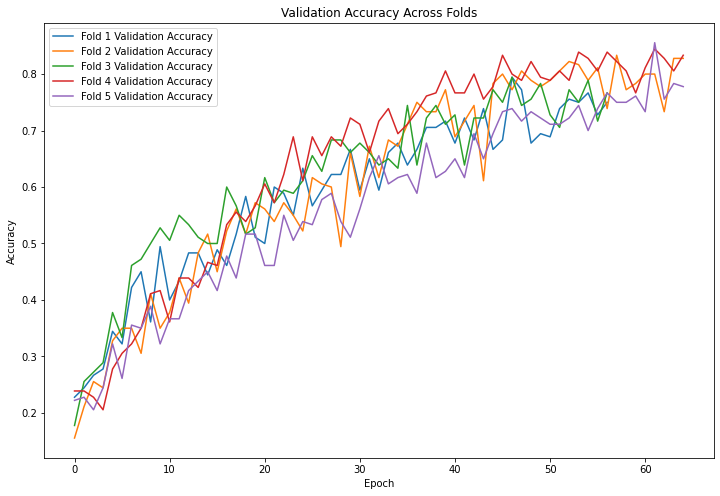

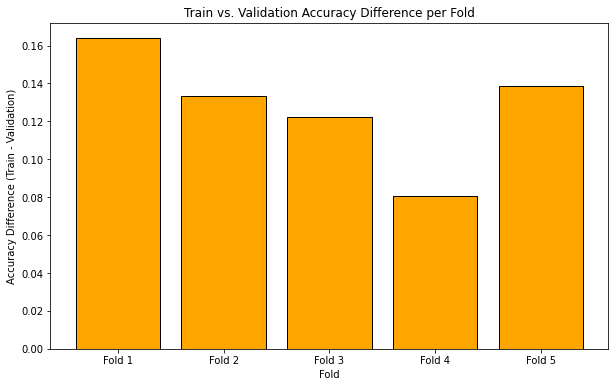

Cross-validation scores: [76.11111402511597, 81.66666626930237, 79.44444417953491, 81.66666626930237, 75.0]
Mean Accuracy: 78.78%
Accuracy Standard Deviation: 2.78%


accuracy_diff,█▅▅▁▆
final_validation_accuracy,▂█▆█▁
fold,▁▃▅▆█
fold_train_accuracy,▃█▁▃▄
fold_val_accuracy,▁█▂█▃
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,0.13889
final_validation_accuracy,75.0
fold,5
fold_train_accuracy,0.91667


wandb: Agent Starting Run: oklgbkd1 with config:
wandb: 	epoch: 51
wandb: 	learning_rate: 0.005090826000466094
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/51
23/23 [==============================] - 11s 442ms/step - loss: 2.2562 - accuracy: 0.1889 - val_loss: 1.8415 - val_accuracy: 0.1722
Epoch 2/51
23/23 [==============================] - 10s 422ms/step - loss: 1.8315 - accuracy: 0.1958 - val_loss: 1.8136 - val_accuracy: 0.1944
Epoch 3/51
23/23 [==============================] - 10s 413ms/step - loss: 1.7777 - accuracy: 0.2222 - val_loss: 1.7770 - val_accuracy: 0.2889
Epoch 4/51
23/23 [==============================] - 10s 418ms/step - loss: 1.7291 - accuracy: 0.2236 - val_loss: 1.7240 - val_accuracy: 0.2444
Epoch 5/51
23/23 [==============================] - 10s 426ms/step - loss: 1.6954 - accuracy: 0.2542 - val_loss: 1.7381 - val_accuracy: 0.2500
Epoch 6/51
23/23 [==============================] - 10s 419ms/step - loss: 1.6821 - accura

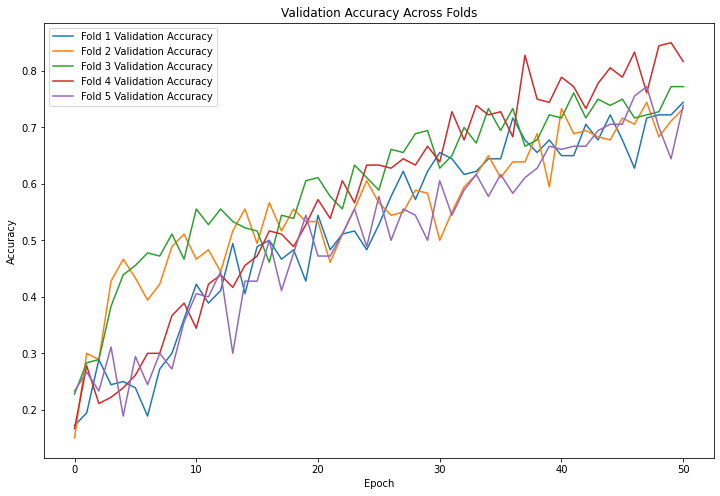

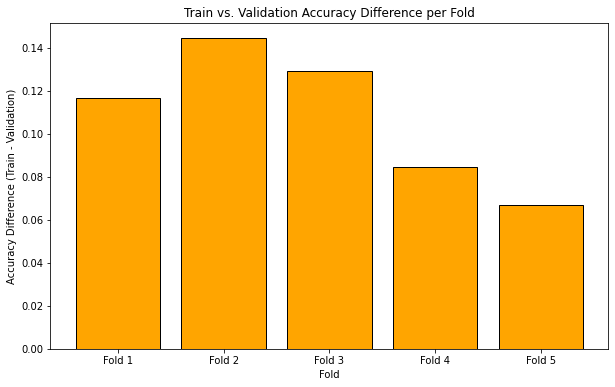

Cross-validation scores: [75.55555701255798, 73.88888597488403, 78.88888716697693, 83.33333134651184, 74.44444298744202]
Mean Accuracy: 77.22%
Accuracy Standard Deviation: 3.51%


accuracy_diff,▆█▇▃▁
final_validation_accuracy,▂▁▅█▁
fold,▁▃▅▆█
fold_train_accuracy,▅▆██▁
fold_val_accuracy,▂▁▄█▁
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,0.06667
final_validation_accuracy,74.44444
fold,5
fold_train_accuracy,0.80556


wandb: Agent Starting Run: r7slf077 with config:
wandb: 	epoch: 85
wandb: 	learning_rate: 0.002787318266808974
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/85
23/23 [==============================] - 11s 435ms/step - loss: 2.2481 - accuracy: 0.2083 - val_loss: 1.9761 - val_accuracy: 0.2222
Epoch 2/85
23/23 [==============================] - 10s 408ms/step - loss: 1.8244 - accuracy: 0.2389 - val_loss: 1.7542 - val_accuracy: 0.2444
Epoch 3/85
23/23 [==============================] - 10s 411ms/step - loss: 1.6638 - accuracy: 0.2764 - val_loss: 1.5571 - val_accuracy: 0.3222
Epoch 4/85
23/23 [==============================] - 10s 411ms/step - loss: 1.5242 - accuracy: 0.3722 - val_loss: 1.5080 - val_accuracy: 0.3167
Epoch 5/85
23/23 [==============================] - 10s 411ms/step - loss: 1.4479 - accuracy: 0.3889 - val_loss: 1.4334 - val_accuracy: 0.4000
Epoch 6/85
23/23 [==============================] - 10s 415ms/step - loss: 1.3820 - accura

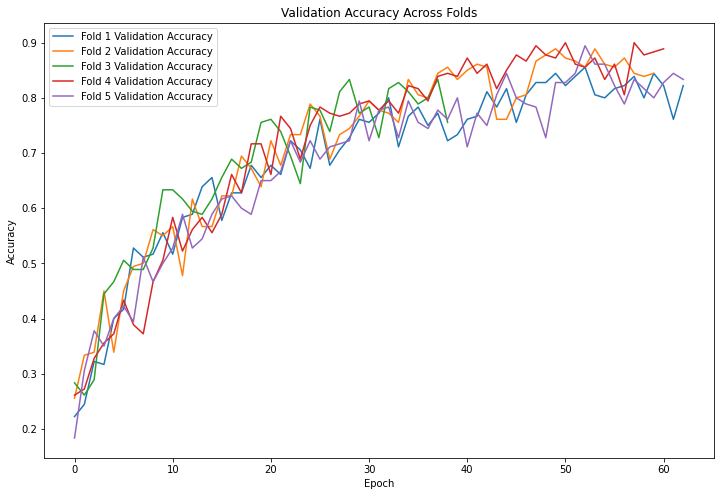

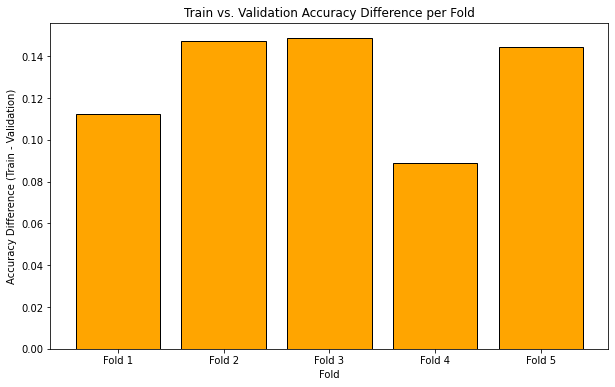

Cross-validation scores: [85.00000238418579, 91.11111164093018, 83.88888835906982, 85.5555534362793, 89.99999761581421]
Mean Accuracy: 87.11%
Accuracy Standard Deviation: 2.88%


accuracy_diff,▄██▁█
final_validation_accuracy,▂█▁▃▇
fold,▁▃▅▆█
fold_train_accuracy,▃█▁▇▇
fold_val_accuracy,▅▆▁█▅
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,0.14444
final_validation_accuracy,90.0
fold,5
fold_train_accuracy,0.97778


wandb: Agent Starting Run: ypdbfm0y with config:
wandb: 	epoch: 66
wandb: 	learning_rate: 0.006543811245922592
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/66
23/23 [==============================] - 11s 442ms/step - loss: 2.0547 - accuracy: 0.2069 - val_loss: 1.6817 - val_accuracy: 0.2333
Epoch 2/66
23/23 [==============================] - 10s 418ms/step - loss: 1.5892 - accuracy: 0.3319 - val_loss: 1.5473 - val_accuracy: 0.3667
Epoch 3/66
23/23 [==============================] - 10s 425ms/step - loss: 1.4868 - accuracy: 0.3694 - val_loss: 1.5811 - val_accuracy: 0.3778
Epoch 4/66
23/23 [==============================] - 10s 410ms/step - loss: 1.4702 - accuracy: 0.3694 - val_loss: 1.4589 - val_accuracy: 0.3889
Epoch 5/66
23/23 [==============================] - 10s 418ms/step - loss: 1.3815 - accuracy: 0.4403 - val_loss: 1.4844 - val_accuracy: 0.4222
Epoch 6/66
23/23 [==============================] - 10s 424ms/step - loss: 1.3412 - accura

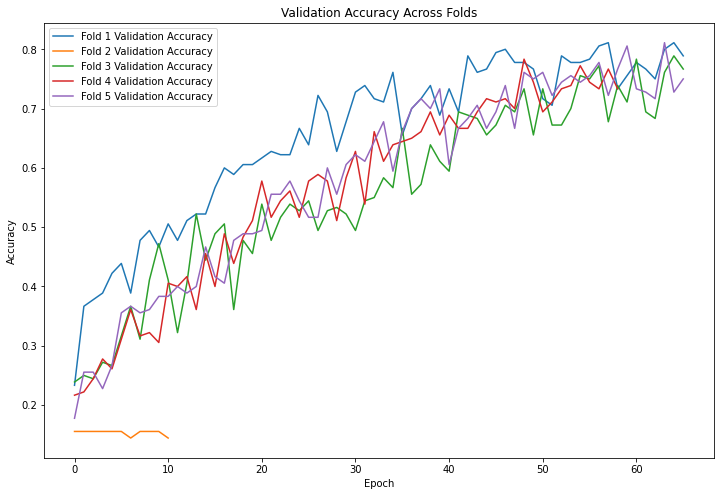

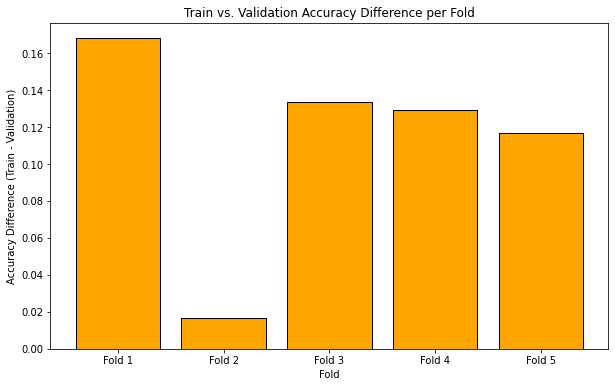

Cross-validation scores: [77.77777910232544, 15.555556118488312, 75.0, 75.55555701255798, 76.66666507720947]
Mean Accuracy: 64.11%
Accuracy Standard Deviation: 24.30%


accuracy_diff,█▁▆▆▆
final_validation_accuracy,█▁███
fold,▁▃▅▆█
fold_train_accuracy,█▁▇▇▇
fold_val_accuracy,█▁█▇█
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,0.11667
final_validation_accuracy,76.66667
fold,5
fold_train_accuracy,0.86667


wandb: Agent Starting Run: oop9eqsm with config:
wandb: 	epoch: 55
wandb: 	learning_rate: 0.005702580896269504
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/55
23/23 [==============================] - 11s 441ms/step - loss: 2.5874 - accuracy: 0.1528 - val_loss: 1.8349 - val_accuracy: 0.2111
Epoch 2/55
23/23 [==============================] - 10s 412ms/step - loss: 1.8196 - accuracy: 0.1861 - val_loss: 1.7941 - val_accuracy: 0.1333
Epoch 3/55
23/23 [==============================] - 10s 411ms/step - loss: 1.8072 - accuracy: 0.1694 - val_loss: 1.7938 - val_accuracy: 0.1556
Epoch 4/55
23/23 [==============================] - 10s 411ms/step - loss: 1.7892 - accuracy: 0.2000 - val_loss: 1.7884 - val_accuracy: 0.1556
Epoch 5/55
23/23 [==============================] - 10s 412ms/step - loss: 1.7842 - accuracy: 0.1667 - val_loss: 1.7869 - val_accuracy: 0.1444
Epoch 6/55
23/23 [==============================] - 10s 410ms/step - loss: 1.7545 - accura

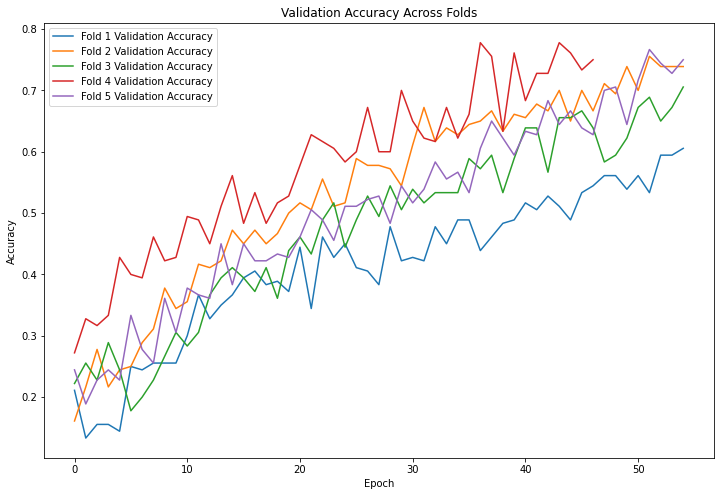

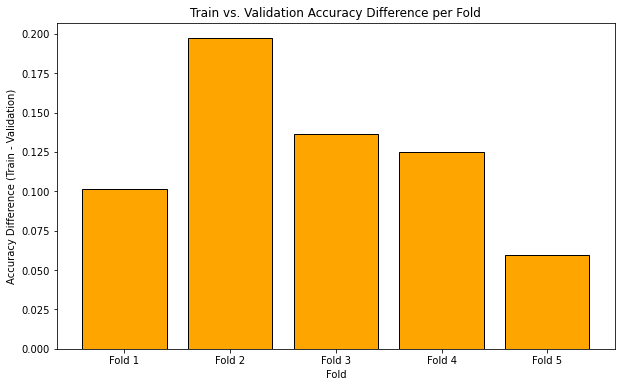

Cross-validation scores: [55.55555820465088, 75.55555701255798, 67.22221970558167, 73.88888597488403, 80.55555820465088]
Mean Accuracy: 70.56%
Accuracy Standard Deviation: 8.63%


accuracy_diff,▃█▅▄▁
final_validation_accuracy,▁▇▄▆█
fold,▁▃▅▆█
fold_train_accuracy,▁█▅▆▄
fold_val_accuracy,▁▇▆██
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,0.05972
final_validation_accuracy,80.55556
fold,5
fold_train_accuracy,0.80972


wandb: Agent Starting Run: 4vns980z with config:
wandb: 	epoch: 55
wandb: 	learning_rate: 0.009905315562052038
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/55
23/23 [==============================] - 11s 439ms/step - loss: 2.5586 - accuracy: 0.1903 - val_loss: 1.7764 - val_accuracy: 0.2389
Epoch 2/55
23/23 [==============================] - 10s 417ms/step - loss: 1.7583 - accuracy: 0.1903 - val_loss: 1.7202 - val_accuracy: 0.2167
Epoch 3/55
23/23 [==============================] - 9s 409ms/step - loss: 1.7204 - accuracy: 0.2347 - val_loss: 1.7485 - val_accuracy: 0.1722
Epoch 4/55
23/23 [==============================] - 10s 423ms/step - loss: 1.6980 - accuracy: 0.2417 - val_loss: 1.6880 - val_accuracy: 0.2389
Epoch 5/55
23/23 [==============================] - 10s 420ms/step - loss: 1.6754 - accuracy: 0.2528 - val_loss: 1.6167 - val_accuracy: 0.2889
Epoch 6/55
23/23 [==============================] - 10s 415ms/step - loss: 1.6954 - accurac

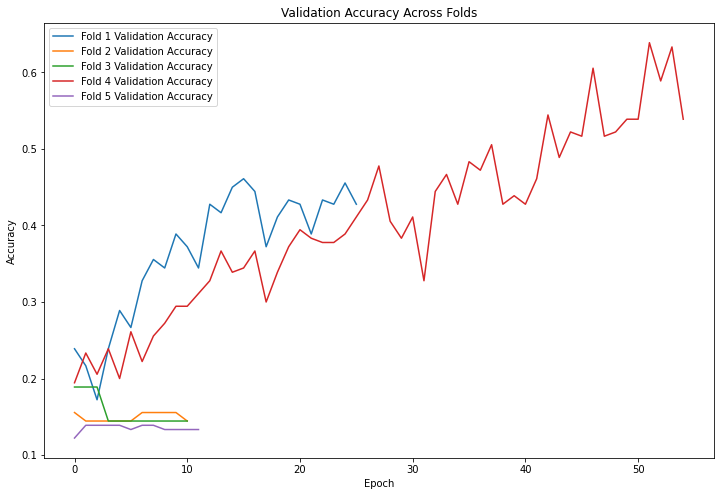

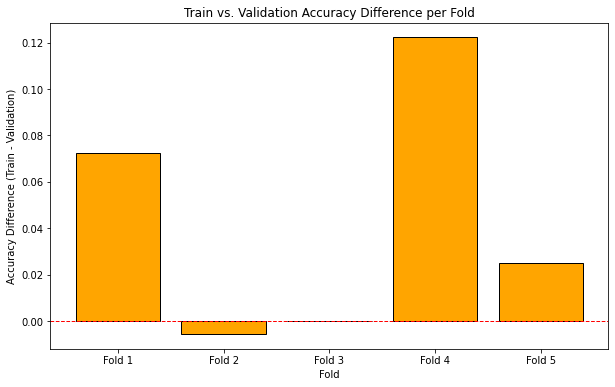

Cross-validation scores: [48.33333194255829, 15.555556118488312, 18.888889253139496, 55.55555820465088, 13.88888955116272]
Mean Accuracy: 30.44%
Accuracy Standard Deviation: 17.78%


accuracy_diff,▅▁▁█▃
final_validation_accuracy,▇▁▂█▁
fold,▁▃▅▆█
fold_train_accuracy,▆▁▁█▁
fold_val_accuracy,▆▁▁█▁
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,0.025
final_validation_accuracy,13.88889
fold,5
fold_train_accuracy,0.15833


wandb: Agent Starting Run: 7nfvrv5q with config:
wandb: 	epoch: 80
wandb: 	learning_rate: 0.00829800500369585
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/80
23/23 [==============================] - 12s 450ms/step - loss: 2.4279 - accuracy: 0.2125 - val_loss: 1.8265 - val_accuracy: 0.2333
Epoch 2/80
23/23 [==============================] - 10s 413ms/step - loss: 1.7414 - accuracy: 0.2222 - val_loss: 1.7667 - val_accuracy: 0.2611
Epoch 3/80
23/23 [==============================] - 9s 408ms/step - loss: 1.7515 - accuracy: 0.2306 - val_loss: 1.7105 - val_accuracy: 0.2444
Epoch 4/80
23/23 [==============================] - 9s 409ms/step - loss: 1.7131 - accuracy: 0.2653 - val_loss: 1.7225 - val_accuracy: 0.2833
Epoch 5/80
23/23 [==============================] - 10s 417ms/step - loss: 1.7184 - accuracy: 0.2556 - val_loss: 1.7237 - val_accuracy: 0.1889
Epoch 6/80
23/23 [==============================] - 10s 410ms/step - loss: 1.7043 - accuracy

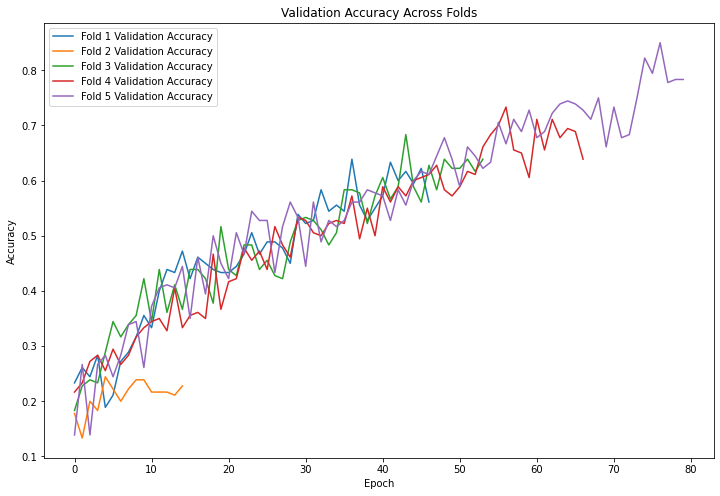

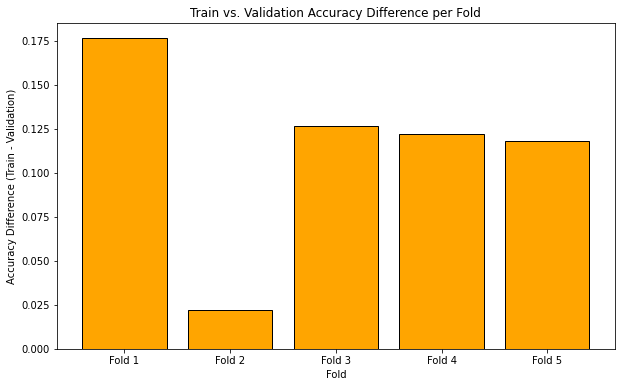

Cross-validation scores: [61.11111044883728, 24.444444477558136, 66.66666865348816, 73.33333492279053, 72.22222089767456]
Mean Accuracy: 59.56%
Accuracy Standard Deviation: 18.09%


accuracy_diff,█▁▆▆▅
final_validation_accuracy,▆▁▇██
fold,▁▃▅▆█
fold_train_accuracy,▆▁▇▆█
fold_val_accuracy,▅▁▆▆█
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,0.11806
final_validation_accuracy,72.22222
fold,5
fold_train_accuracy,0.90139


wandb: Agent Starting Run: gj487zfc with config:
wandb: 	epoch: 60
wandb: 	learning_rate: 0.0029019135391418955
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/60
23/23 [==============================] - 11s 445ms/step - loss: 2.1151 - accuracy: 0.2236 - val_loss: 1.7935 - val_accuracy: 0.1833
Epoch 2/60
23/23 [==============================] - 10s 417ms/step - loss: 1.7763 - accuracy: 0.2333 - val_loss: 1.6996 - val_accuracy: 0.2389
Epoch 3/60
23/23 [==============================] - 10s 415ms/step - loss: 1.6551 - accuracy: 0.2833 - val_loss: 1.6485 - val_accuracy: 0.3056
Epoch 4/60
23/23 [==============================] - 10s 412ms/step - loss: 1.5339 - accuracy: 0.3597 - val_loss: 1.5451 - val_accuracy: 0.3889
Epoch 5/60
23/23 [==============================] - 10s 411ms/step - loss: 1.3626 - accuracy: 0.4417 - val_loss: 1.4680 - val_accuracy: 0.3611
Epoch 6/60
23/23 [==============================] - 10s 413ms/step - loss: 1.3571 - accura

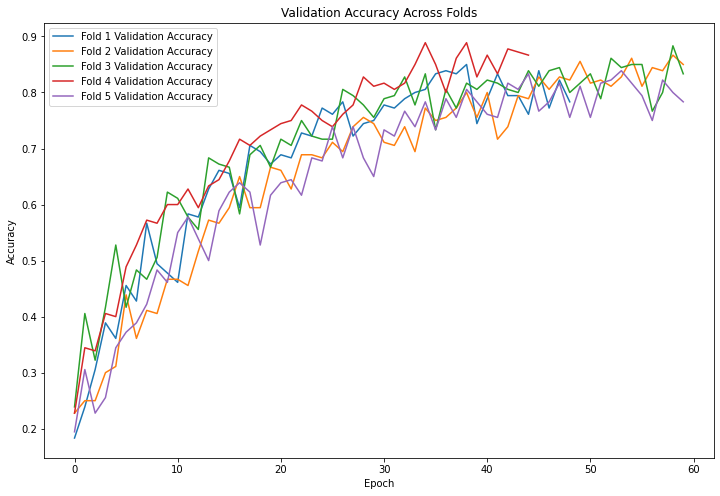

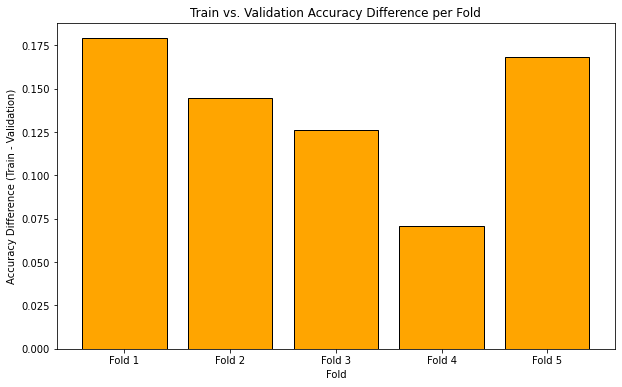

Cross-validation scores: [81.66666626930237, 87.22222447395325, 85.5555534362793, 89.99999761581421, 78.88888716697693]
Mean Accuracy: 84.67%
Accuracy Standard Deviation: 3.95%


accuracy_diff,█▆▅▁▇
final_validation_accuracy,▃▆▅█▁
fold,▁▃▅▆█
fold_train_accuracy,▄█▄▁▃
fold_val_accuracy,▁▇▅█▁
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,0.16806
final_validation_accuracy,78.88889
fold,5
fold_train_accuracy,0.95139


wandb: Agent Starting Run: 6lf7cnrt with config:
wandb: 	epoch: 90
wandb: 	learning_rate: 0.0011855734429228764
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/90
23/23 [==============================] - 11s 429ms/step - loss: 1.8880 - accuracy: 0.2083 - val_loss: 1.6931 - val_accuracy: 0.3056
Epoch 2/90
23/23 [==============================] - 10s 416ms/step - loss: 1.5954 - accuracy: 0.3486 - val_loss: 1.5885 - val_accuracy: 0.3556
Epoch 3/90
23/23 [==============================] - 10s 413ms/step - loss: 1.4393 - accuracy: 0.4042 - val_loss: 1.4200 - val_accuracy: 0.4167
Epoch 4/90
23/23 [==============================] - 10s 413ms/step - loss: 1.3528 - accuracy: 0.4625 - val_loss: 1.4225 - val_accuracy: 0.4556
Epoch 5/90
23/23 [==============================] - 10s 414ms/step - loss: 1.2602 - accuracy: 0.5000 - val_loss: 1.4210 - val_accuracy: 0.4333
Epoch 6/90
23/23 [==============================] - 10s 410ms/step - loss: 1.2054 - accura

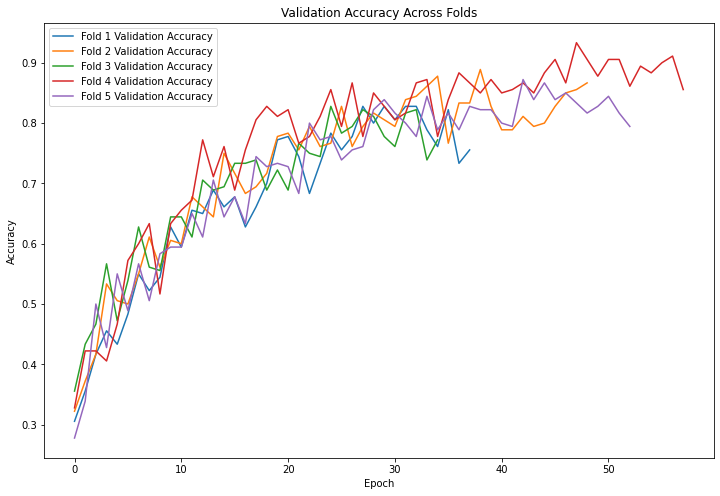

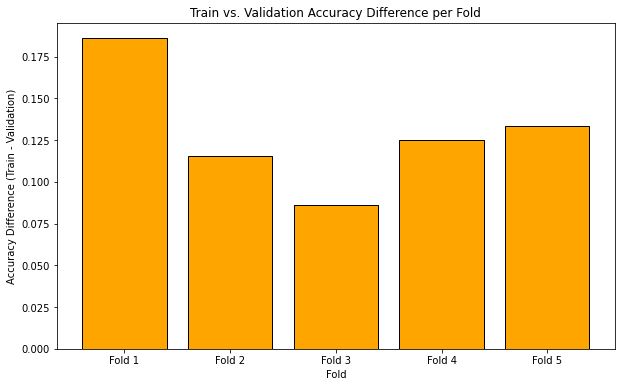

Cross-validation scores: [81.66666626930237, 86.66666746139526, 78.33333611488342, 91.66666865348816, 83.33333134651184]
Mean Accuracy: 84.33%
Accuracy Standard Deviation: 4.55%


accuracy_diff,█▃▁▄▄
final_validation_accuracy,▃▅▁█▄
fold,▁▃▅▆█
fold_train_accuracy,▆█▁█▅
fold_val_accuracy,▁█▂▇▃
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,0.13333
final_validation_accuracy,83.33333
fold,5
fold_train_accuracy,0.92778


wandb: Agent Starting Run: ur543n2s with config:
wandb: 	epoch: 77
wandb: 	learning_rate: 0.008443850498764768
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Fold: 1 ==================================================================
Found 720 validated image filenames belonging to 6 classes.
Found 180 validated image filenames belonging to 6 classes.
Epoch 1/77
23/23 [==============================] - 11s 457ms/step - loss: 2.9751 - accuracy: 0.1597 - val_loss: 1.9450 - val_accuracy: 0.1889
Epoch 2/77
23/23 [==============================] - 10s 434ms/step - loss: 1.8595 - accuracy: 0.1722 - val_loss: 1.7819 - val_accuracy: 0.1889
Epoch 3/77
23/23 [==============================] - 10s 430ms/step - loss: 1.7923 - accuracy: 0.1986 - val_loss: 1.7411 - val_accuracy: 0.2111
Epoch 4/77
23/23 [==============================] - 10s 425ms/step - loss: 1.7267 - accuracy: 0.2361 - val_loss: 1.7561 - val_accuracy: 0.1944
Epoch 5/77
23/23 [==============================] - 10s 413ms/step - loss: 1.7393 - accuracy: 0.2250 - val_loss: 1.7055 - val_accuracy: 0.2778
Epoch 6/77
23/23 [==============================] - 10s 424ms/step - loss: 1.6863 - accura

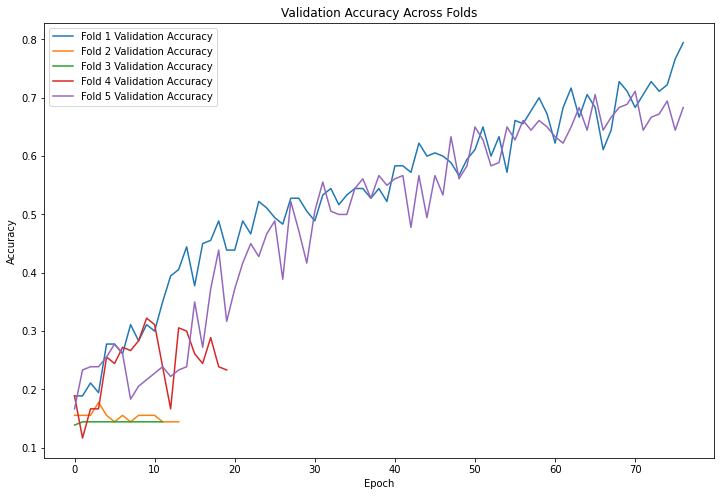

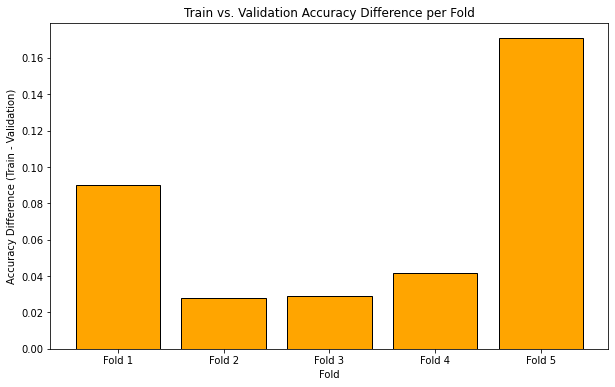

Cross-validation scores: [78.33333611488342, 17.777778208255768, 14.444445073604584, 32.22222328186035, 63.88888955116272]
Mean Accuracy: 41.33%
Accuracy Standard Deviation: 25.45%


accuracy_diff,▄▁▁▂█
final_validation_accuracy,█▁▁▃▆
fold,▁▃▅▆█
fold_train_accuracy,█▁▁▂█
fold_val_accuracy,█▁▁▂▇
mean_accuracy,▁
std_accuracy,▁
accuracy_diff,0.17083
final_validation_accuracy,63.88889
fold,5
fold_train_accuracy,0.85417


In [38]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = "wisdom-jihyekim-aiffel",
                       project = "WandB_with_kfold_used_by_Jindeok_revised_again")


# run the sweep
wandb.agent(sweep_id,
            function=train_with_kfold,
            count=10)